In [628]:
# import everything: 
import pyarrow.parquet as pa 
import pandas as pd
import numpy as np
from pandas import DataFrame
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
import os


# load data: 

In [629]:
df_hbn = pd.read_csv('../data/HBN.csv')
columns = ['id', 'Enrol_Season', 'Age', 'Sex',
            'CGAS-Season', 'Physical-Season', 'FE-Season',
            'FGC-Season', 'BIA-Season', 
            'PAQ_A-Season', 'PAQ_C-Season',
            'PCIAT-Season', 'SDS-Season', 
            'PreInt_EduHx-Season', 'sii']

df_hbn_q = df_hbn[columns].copy()
df_hbn_q.head()

,id,Enrol_Season,Age,Sex,CGAS-Season,Physical-Season,FE-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season,sii
0,00008ff9,Fall,5,0,Winter,Fall,NaN,Fall,Fall,NaN,NaN,Fall,NaN,Fall,2.0
1,000fd460,Summer,9,0,NaN,Fall,NaN,Fall,Winter,NaN,Fall,Fall,Fall,Summer,0.0
2,00105258,Summer,10,1,Fall,Fall,Fall,Fall,NaN,NaN,Summer,Fall,Fall,Summer,0.0
3,00115b9f,Winter,9,0,Fall,Summer,Summer,Summer,Summer,NaN,Winter,Summer,Summer,Winter,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN,NaN,NaN


# remove NaN sii,

In [630]:
df_hbn_sii = df_hbn.dropna(subset=['sii'])
df_hbn_sii.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 83 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              2736 non-null   int64  
 1   id                                      2736 non-null   object 
 2   Enrol_Season                            2736 non-null   object 
 3   Age                                     2736 non-null   int64  
 4   Sex                                     2736 non-null   int64  
 5   CGAS-Season                             2342 non-null   object 
 6   CGAS-Score                              2342 non-null   float64
 7   Physical-Season                         2595 non-null   object 
 8   Physical-BMI                            2527 non-null   float64
 9   Physical-Height                         2530 non-null   float64
 10  Physical-Weight                         2572 non-null   float64
 


# then remove NaN columns


<Axes: >

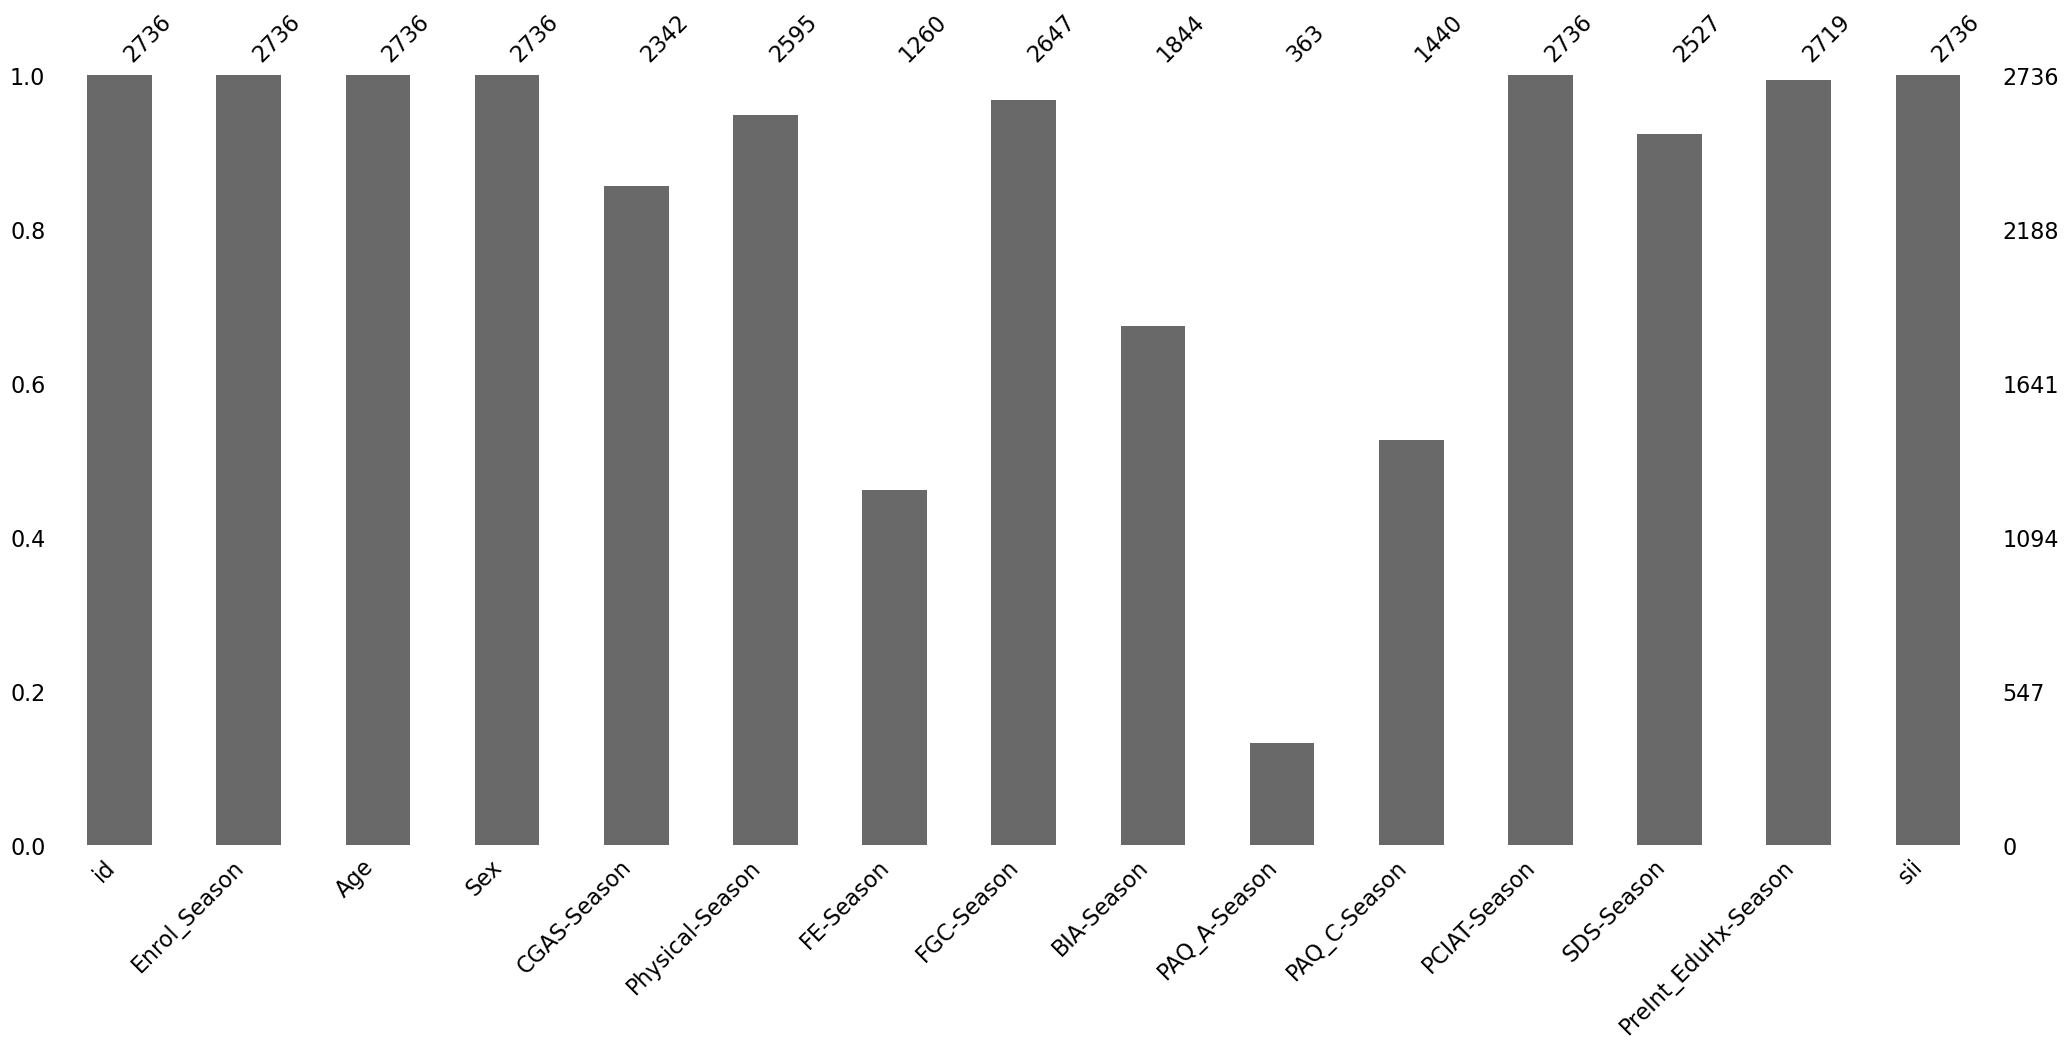

In [631]:
df_hbn_sii_q = df_hbn_sii[columns].copy()
%matplotlib inline
msno.bar(df_hbn_sii_q)

/var/folders/ff/4p_yj_510c95r3qx09wm60bh0000gn/T/ipykernel_89035/3136468885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hbn_sii.loc[:, 'Merged_PAQ-Season'] = df_hbn_sii['PAQ_C-Season'].combine_first(df_hbn_sii['PAQ_A-Season'])
/var/folders/ff/4p_yj_510c95r3qx09wm60bh0000gn/T/ipykernel_89035/3136468885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hbn_sii.loc[:,'Merged_PAQ_Total'] = df_hbn_sii['PAQ_C-PAQ_C_Total'].combine_first(df_hbn_sii['PAQ_A-PAQ_A_Total'])


<Axes: >

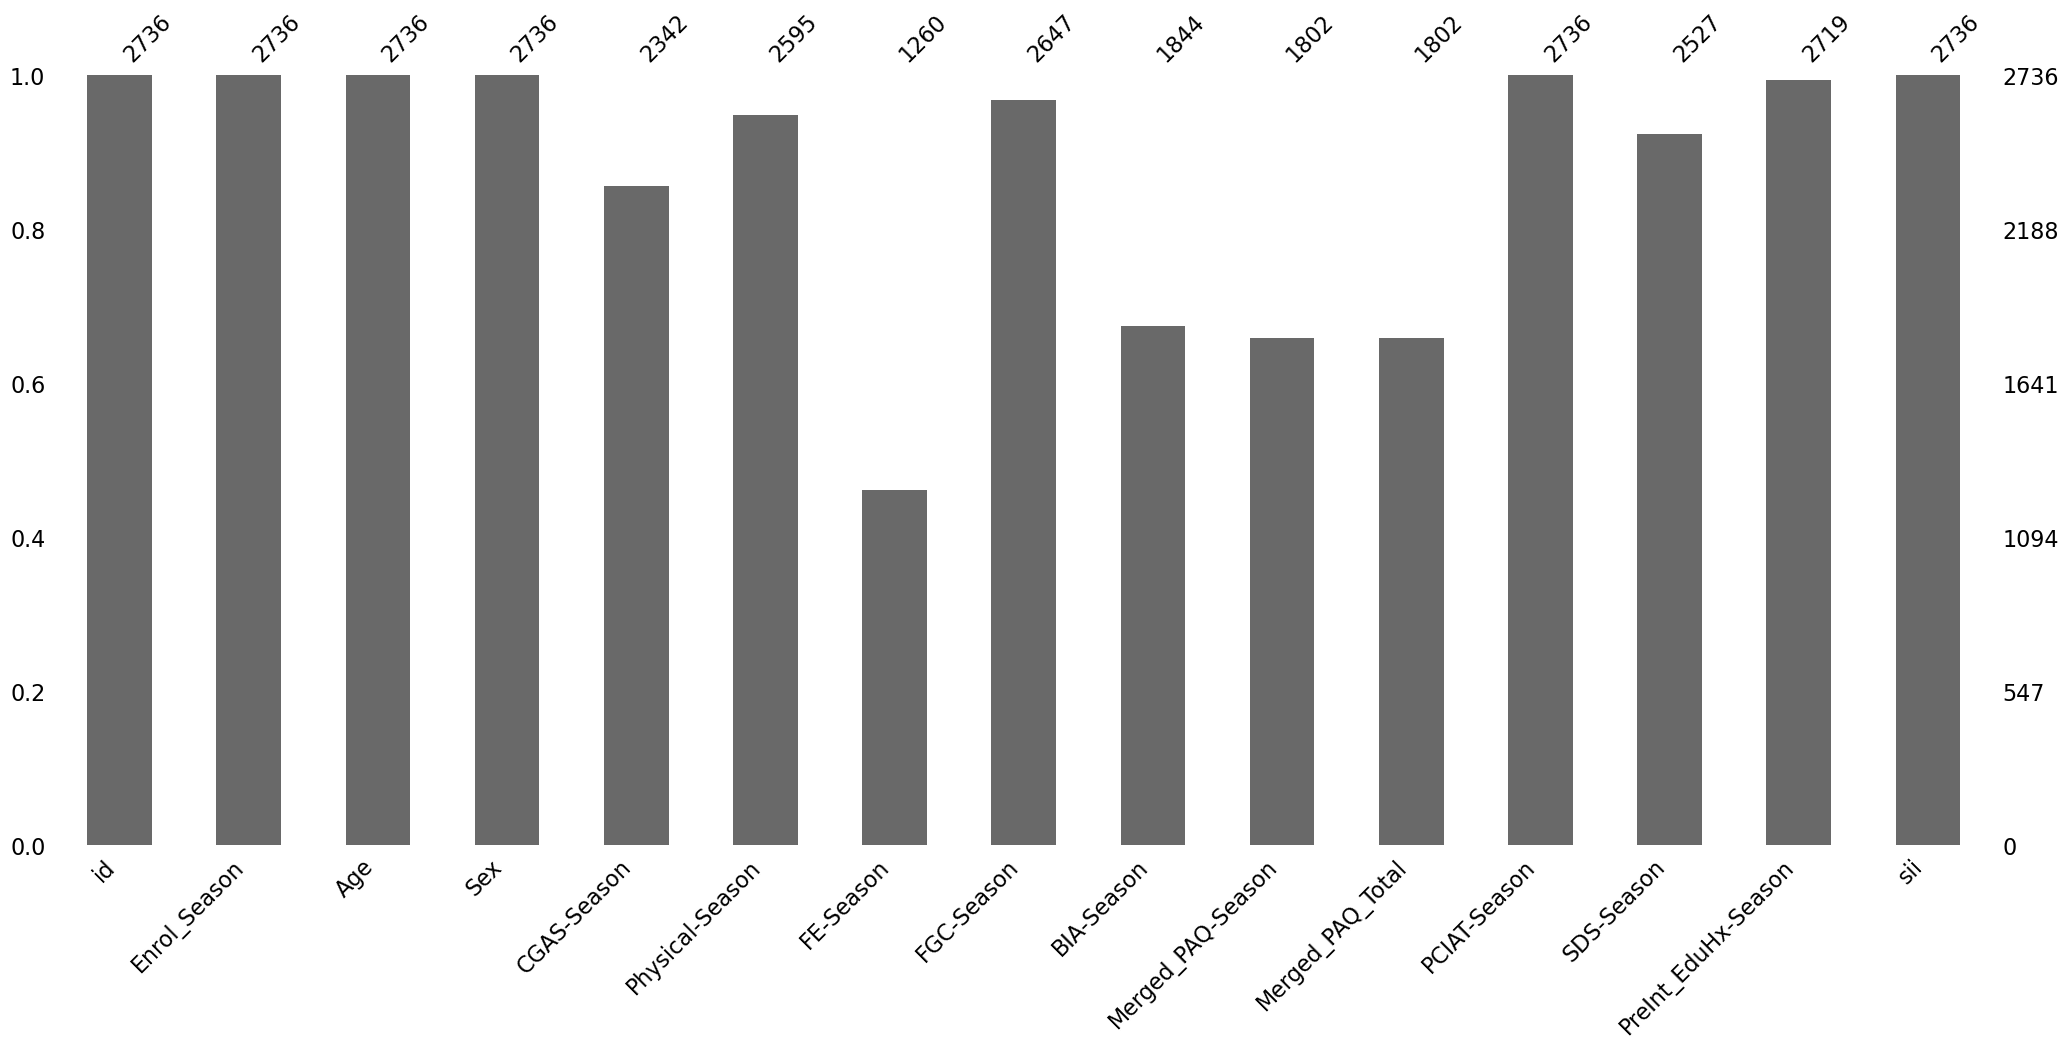

In [632]:
# merge PAQ_A and PAQ_C
df_hbn_sii.loc[:, 'Merged_PAQ-Season'] = df_hbn_sii['PAQ_C-Season'].combine_first(df_hbn_sii['PAQ_A-Season'])
df_hbn_sii.loc[:,'Merged_PAQ_Total'] = df_hbn_sii['PAQ_C-PAQ_C_Total'].combine_first(df_hbn_sii['PAQ_A-PAQ_A_Total'])

columns = ['id', 'Enrol_Season', 'Age', 'Sex',
            'CGAS-Season', 'Physical-Season', 'FE-Season',
            'FGC-Season', 'BIA-Season', 
            'Merged_PAQ-Season', 'Merged_PAQ_Total', 
            'PCIAT-Season', 'SDS-Season', 
            'PreInt_EduHx-Season', 'sii']

df_hbn_sii_q = df_hbn_sii[columns].copy()
%matplotlib inline
msno.bar(df_hbn_sii_q)


/var/folders/ff/4p_yj_510c95r3qx09wm60bh0000gn/T/ipykernel_89035/105669716.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hbn_sii.drop(pciat_columns, axis=1, inplace=True)


<Axes: >

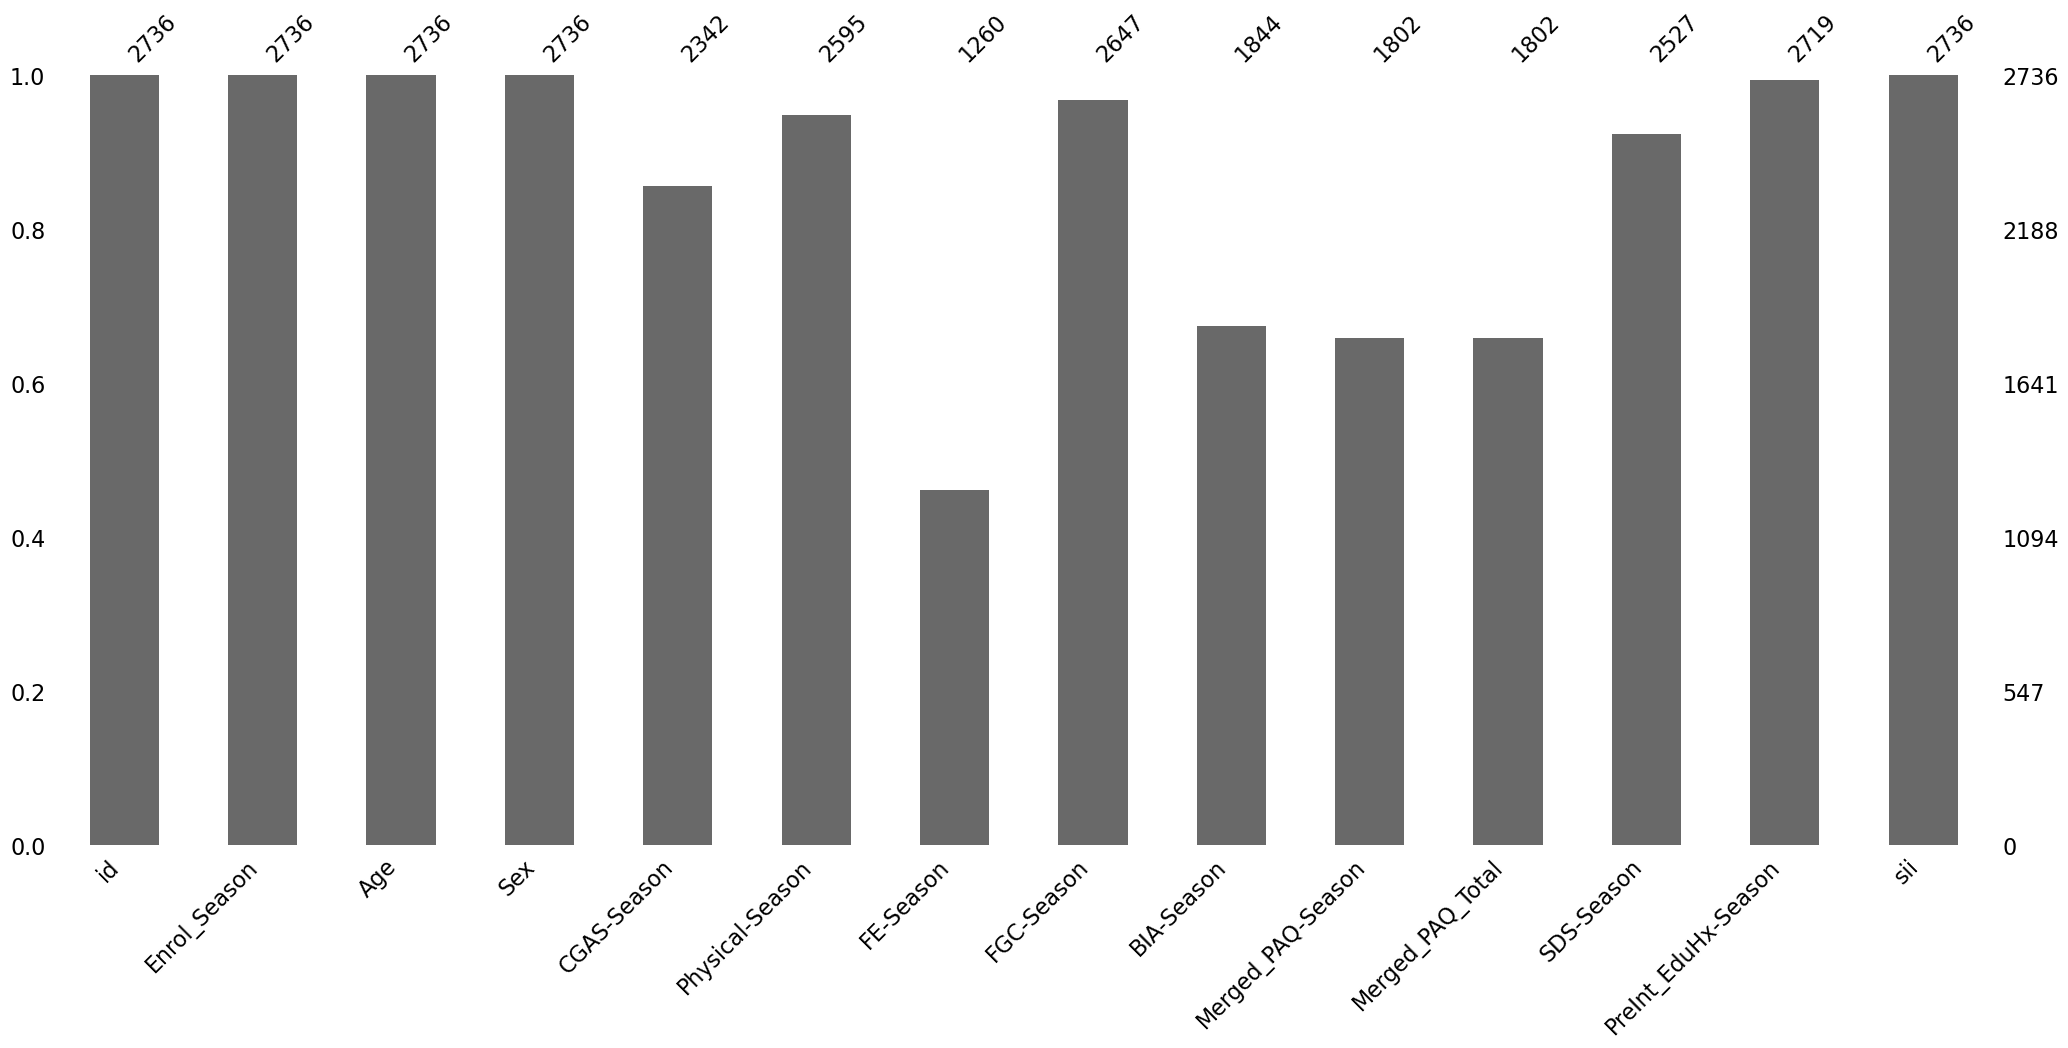

In [633]:
# Drop PCIAT columns: 
pciat_columns = [col for col in df_hbn_sii.columns if col.startswith('PCIAT')]

df_hbn_sii.drop(pciat_columns, axis=1, inplace=True)

columns = ['id', 'Enrol_Season', 'Age', 'Sex',
            'CGAS-Season', 'Physical-Season', 'FE-Season',
            'FGC-Season', 'BIA-Season', 
            'Merged_PAQ-Season', 'Merged_PAQ_Total', 
            'SDS-Season', 
            'PreInt_EduHx-Season', 'sii']

df_hbn_sii_q = df_hbn_sii[columns].copy()
%matplotlib inline
msno.bar(df_hbn_sii_q)

<Axes: >

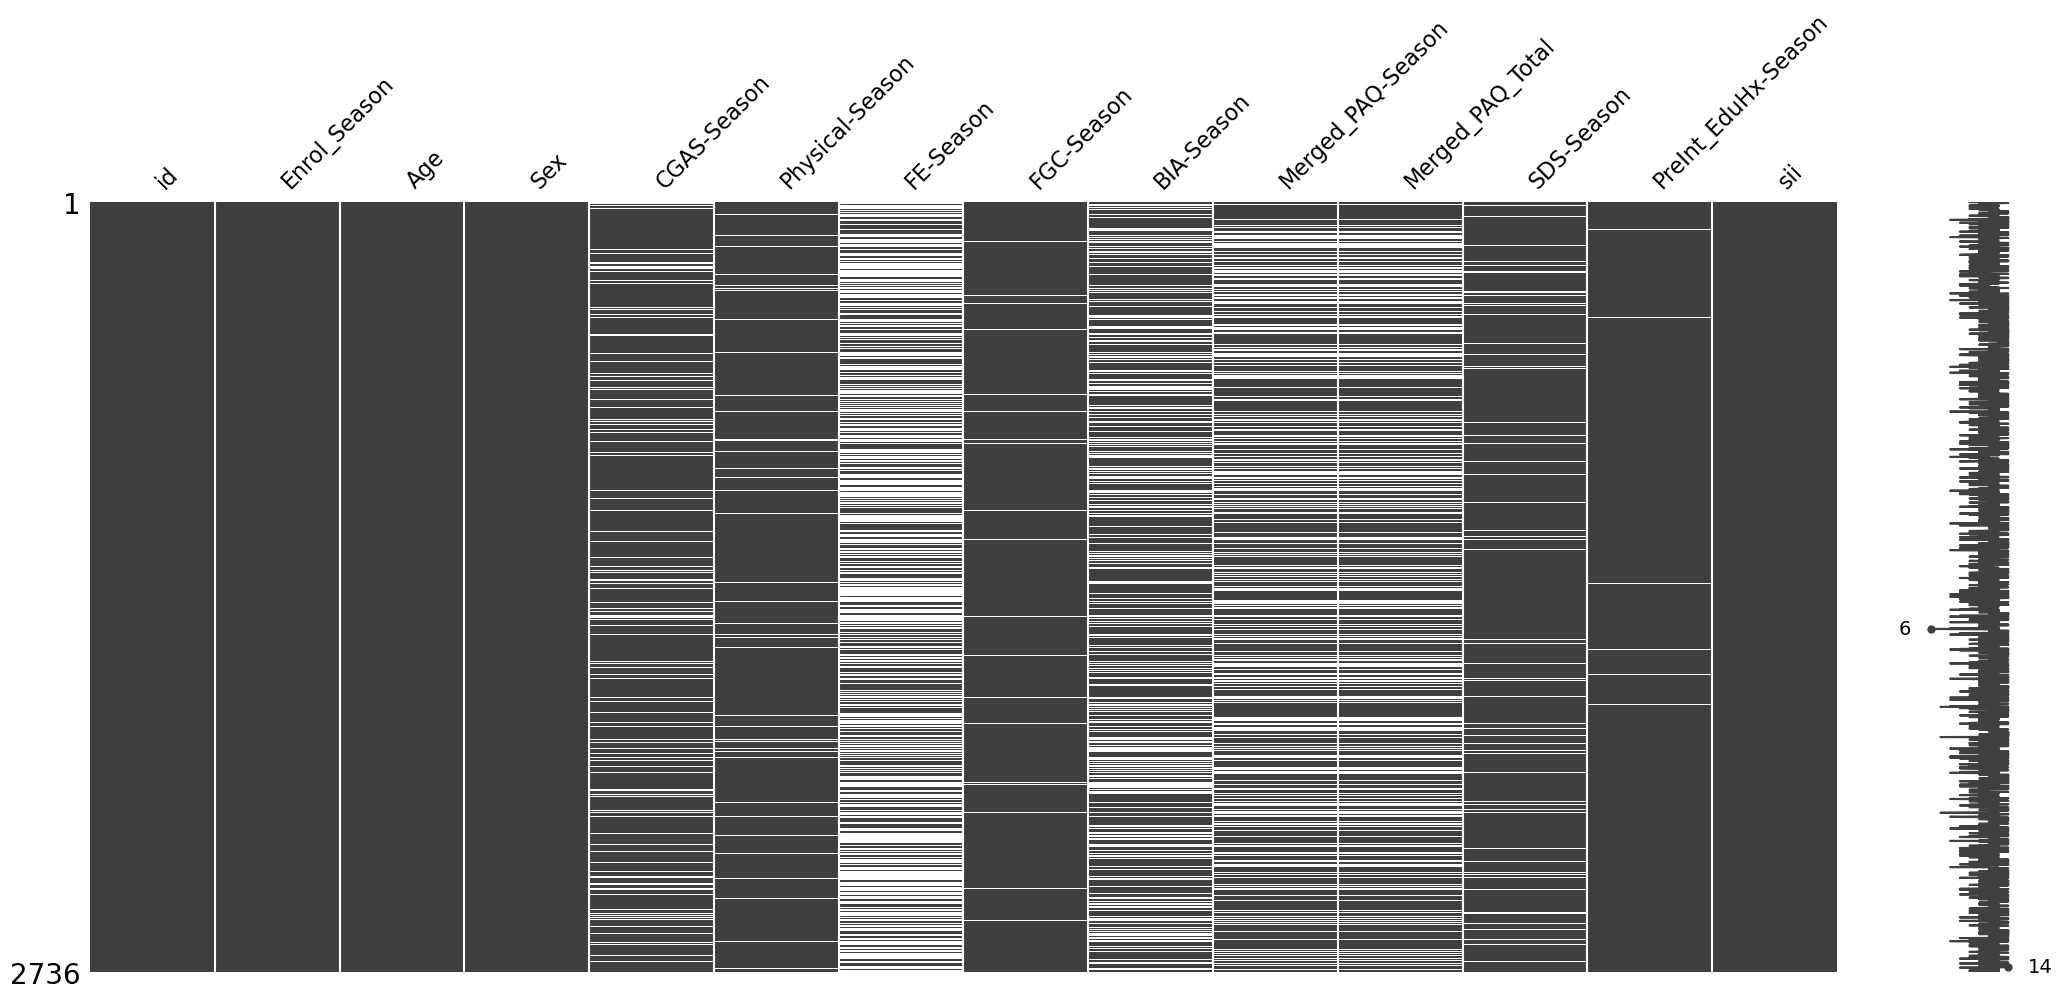

In [634]:
msno.matrix(df_hbn_sii_q)

In [635]:
df_hbn_sii_q_copy = df_hbn_sii.copy()

In [636]:
# Drop rows with more than 4 NaN values in these columns: 
columns_to_check = ['id', 'Enrol_Season', 'Age', 'Sex',
            'CGAS-Season', 'Physical-Season', 'FE-Season',
            'FGC-Season', 'BIA-Season', 
            'Merged_PAQ-Season', 'Merged_PAQ_Total', 
            'SDS-Season', 
            'PreInt_EduHx-Season', 'sii']


df_hbn_sii_q_copy['NaN_count'] = df_hbn_sii_q_copy[columns_to_check].isna().sum(axis=1)
df_hbn_sii_q_copy.NaN_count.describe()

df_hbn_sii_q_dropped_rows = df_hbn_sii_q_copy[df_hbn_sii_q_copy['NaN_count'] <= 4].drop(columns=['NaN_count'])

print(df_hbn_sii_q_dropped_rows.info())
df_hbn_sii = df_hbn_sii_q_dropped_rows.copy()


<class 'pandas.core.frame.DataFrame'>
Index: 2596 entries, 0 to 3958
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              2596 non-null   int64  
 1   id                                      2596 non-null   object 
 2   Enrol_Season                            2596 non-null   object 
 3   Age                                     2596 non-null   int64  
 4   Sex                                     2596 non-null   int64  
 5   CGAS-Season                             2264 non-null   object 
 6   CGAS-Score                              2264 non-null   float64
 7   Physical-Season                         2516 non-null   object 
 8   Physical-BMI                            2460 non-null   float64
 9   Physical-Height                         2463 non-null   float64
 10  Physical-Weight                         2503 non-null   float64
 

<class 'pandas.core.frame.DataFrame'>
Index: 2596 entries, 0 to 3958
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              2596 non-null   int64  
 1   id                                      2596 non-null   object 
 2   Enrol_Season                            2596 non-null   object 
 3   Age                                     2596 non-null   int64  
 4   Sex                                     2596 non-null   int64  
 5   CGAS-Season                             2264 non-null   object 
 6   CGAS-Score                              2264 non-null   float64
 7   Physical-Season                         2516 non-null   object 
 8   Physical-BMI                            2460 non-null   float64
 9   Physical-Height                         2463 non-null   float64
 10  Physical-Weight                         2503 non-null   float64
 

<Axes: >

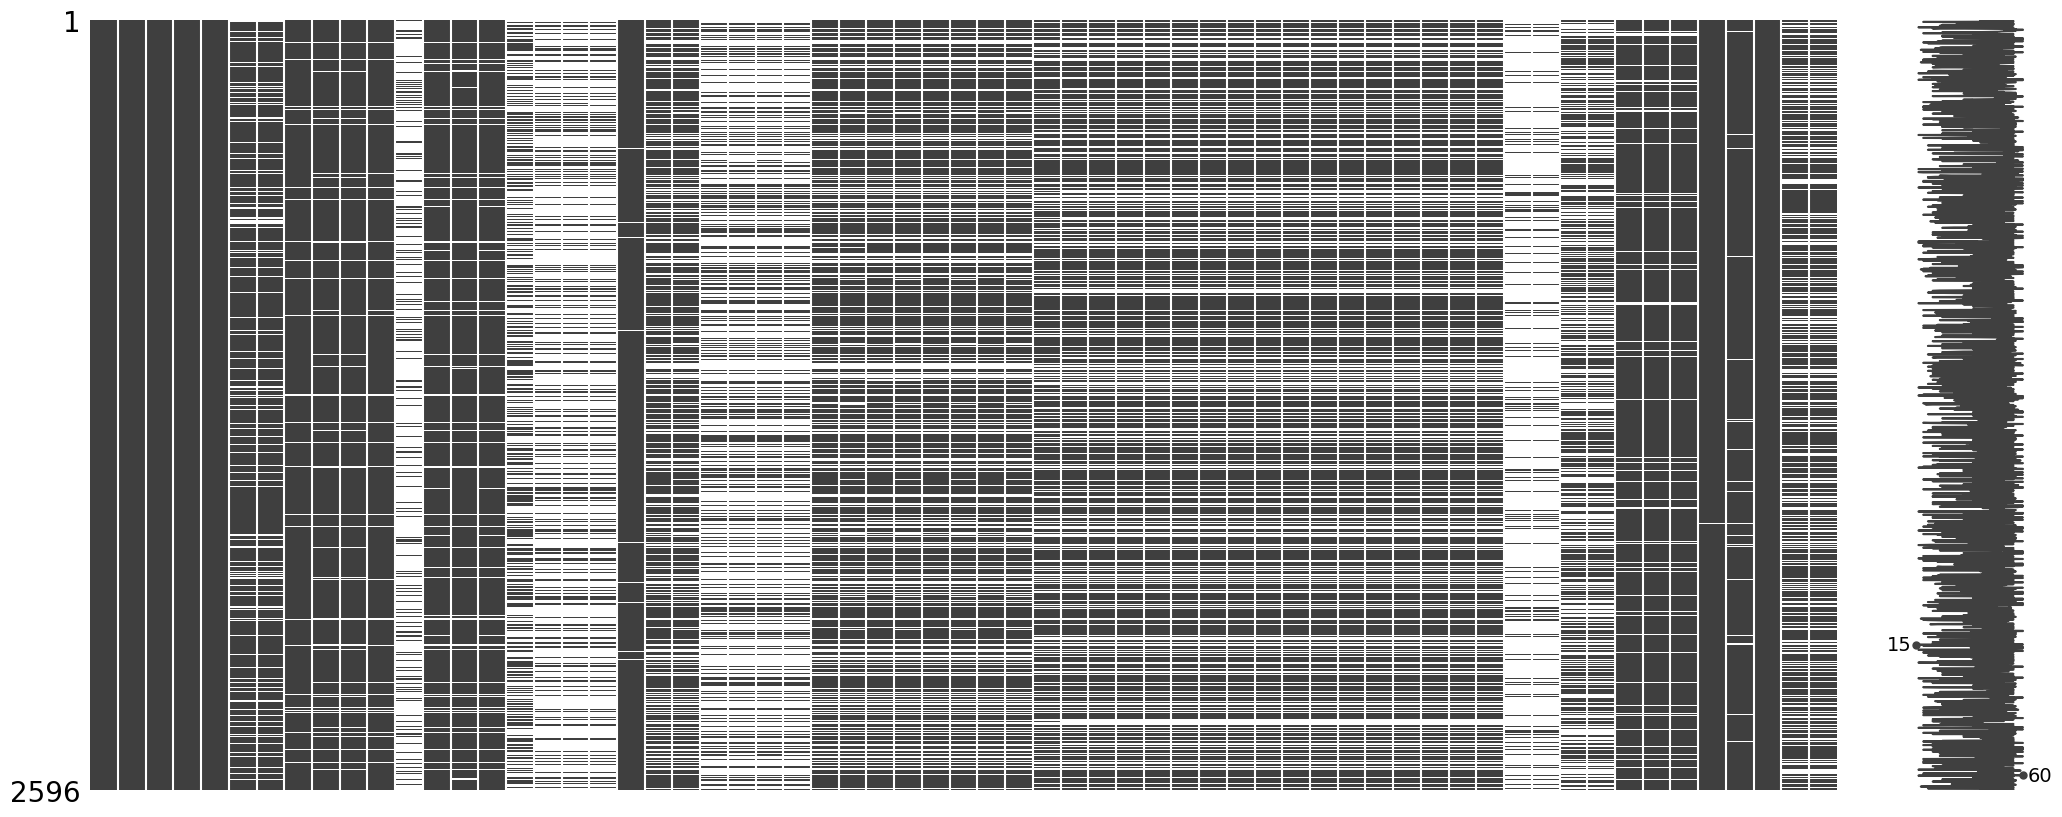

In [637]:
print(df_hbn_sii_q_dropped_rows.info())
msno.matrix(df_hbn_sii_q_dropped_rows)

# Drop Columns with more than 20% NaN values: 


In [638]:
df_hbn_sii_copy = df_hbn_sii.copy()

In [639]:
# columns_to_drop = ['Merged_PAQ-Season', 'Merged_PAQ_Total']
# for col in df_hbn_sii.columns:
#     if col.startswith('FE') or col.startswith('BIA'):
#         columns_to_drop.append(col)

# print(columns_to_drop)
# df_hbn_sii = df_hbn_sii.drop(columns_to_drop, axis=1)

# print(df_hbn_sii.info())

<Axes: >

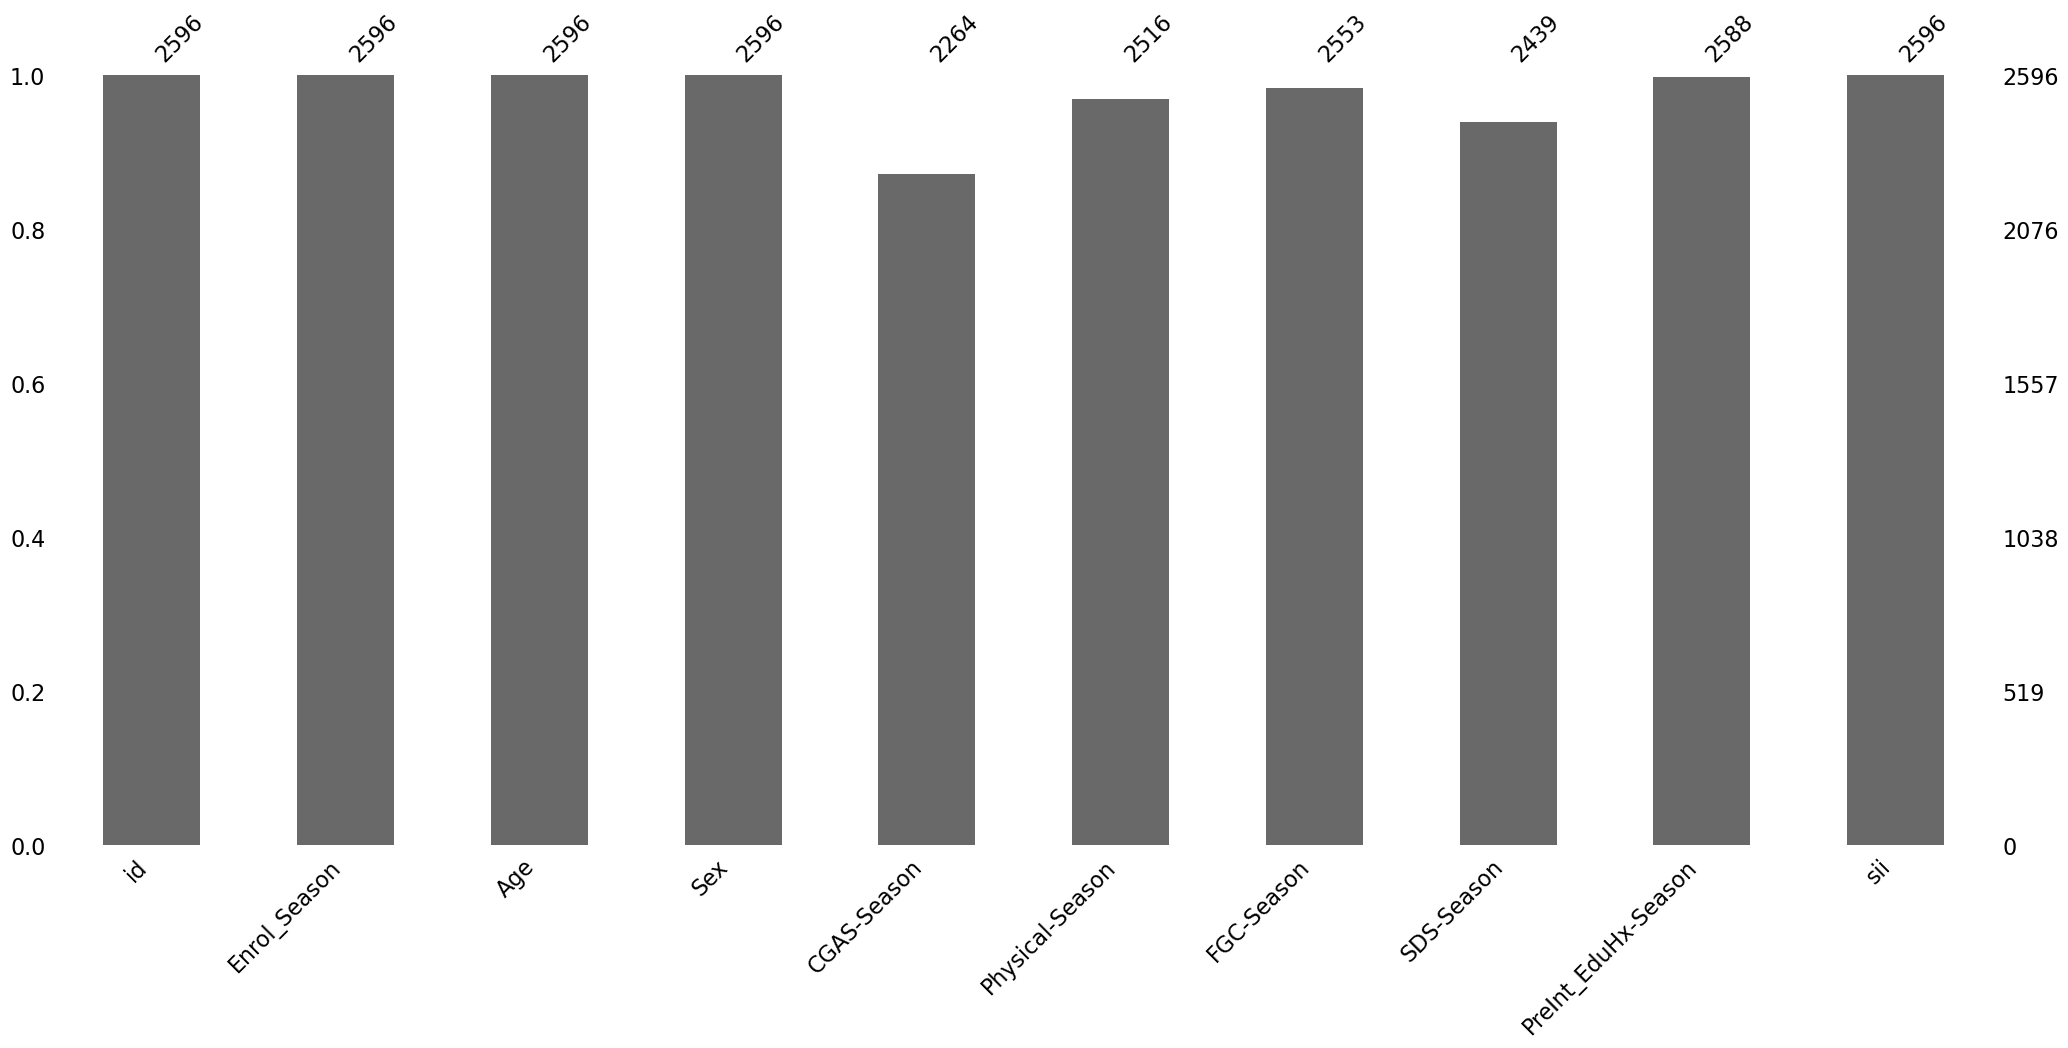

In [640]:
columns = ['id', 'Enrol_Season', 'Age', 'Sex',
            'CGAS-Season', 'Physical-Season',
            'FGC-Season', 
            'SDS-Season', 
            'PreInt_EduHx-Season', 'sii']

df_hbn_sii_q = df_hbn_sii[columns].copy()
%matplotlib inline
msno.bar(df_hbn_sii_q)

<Axes: >

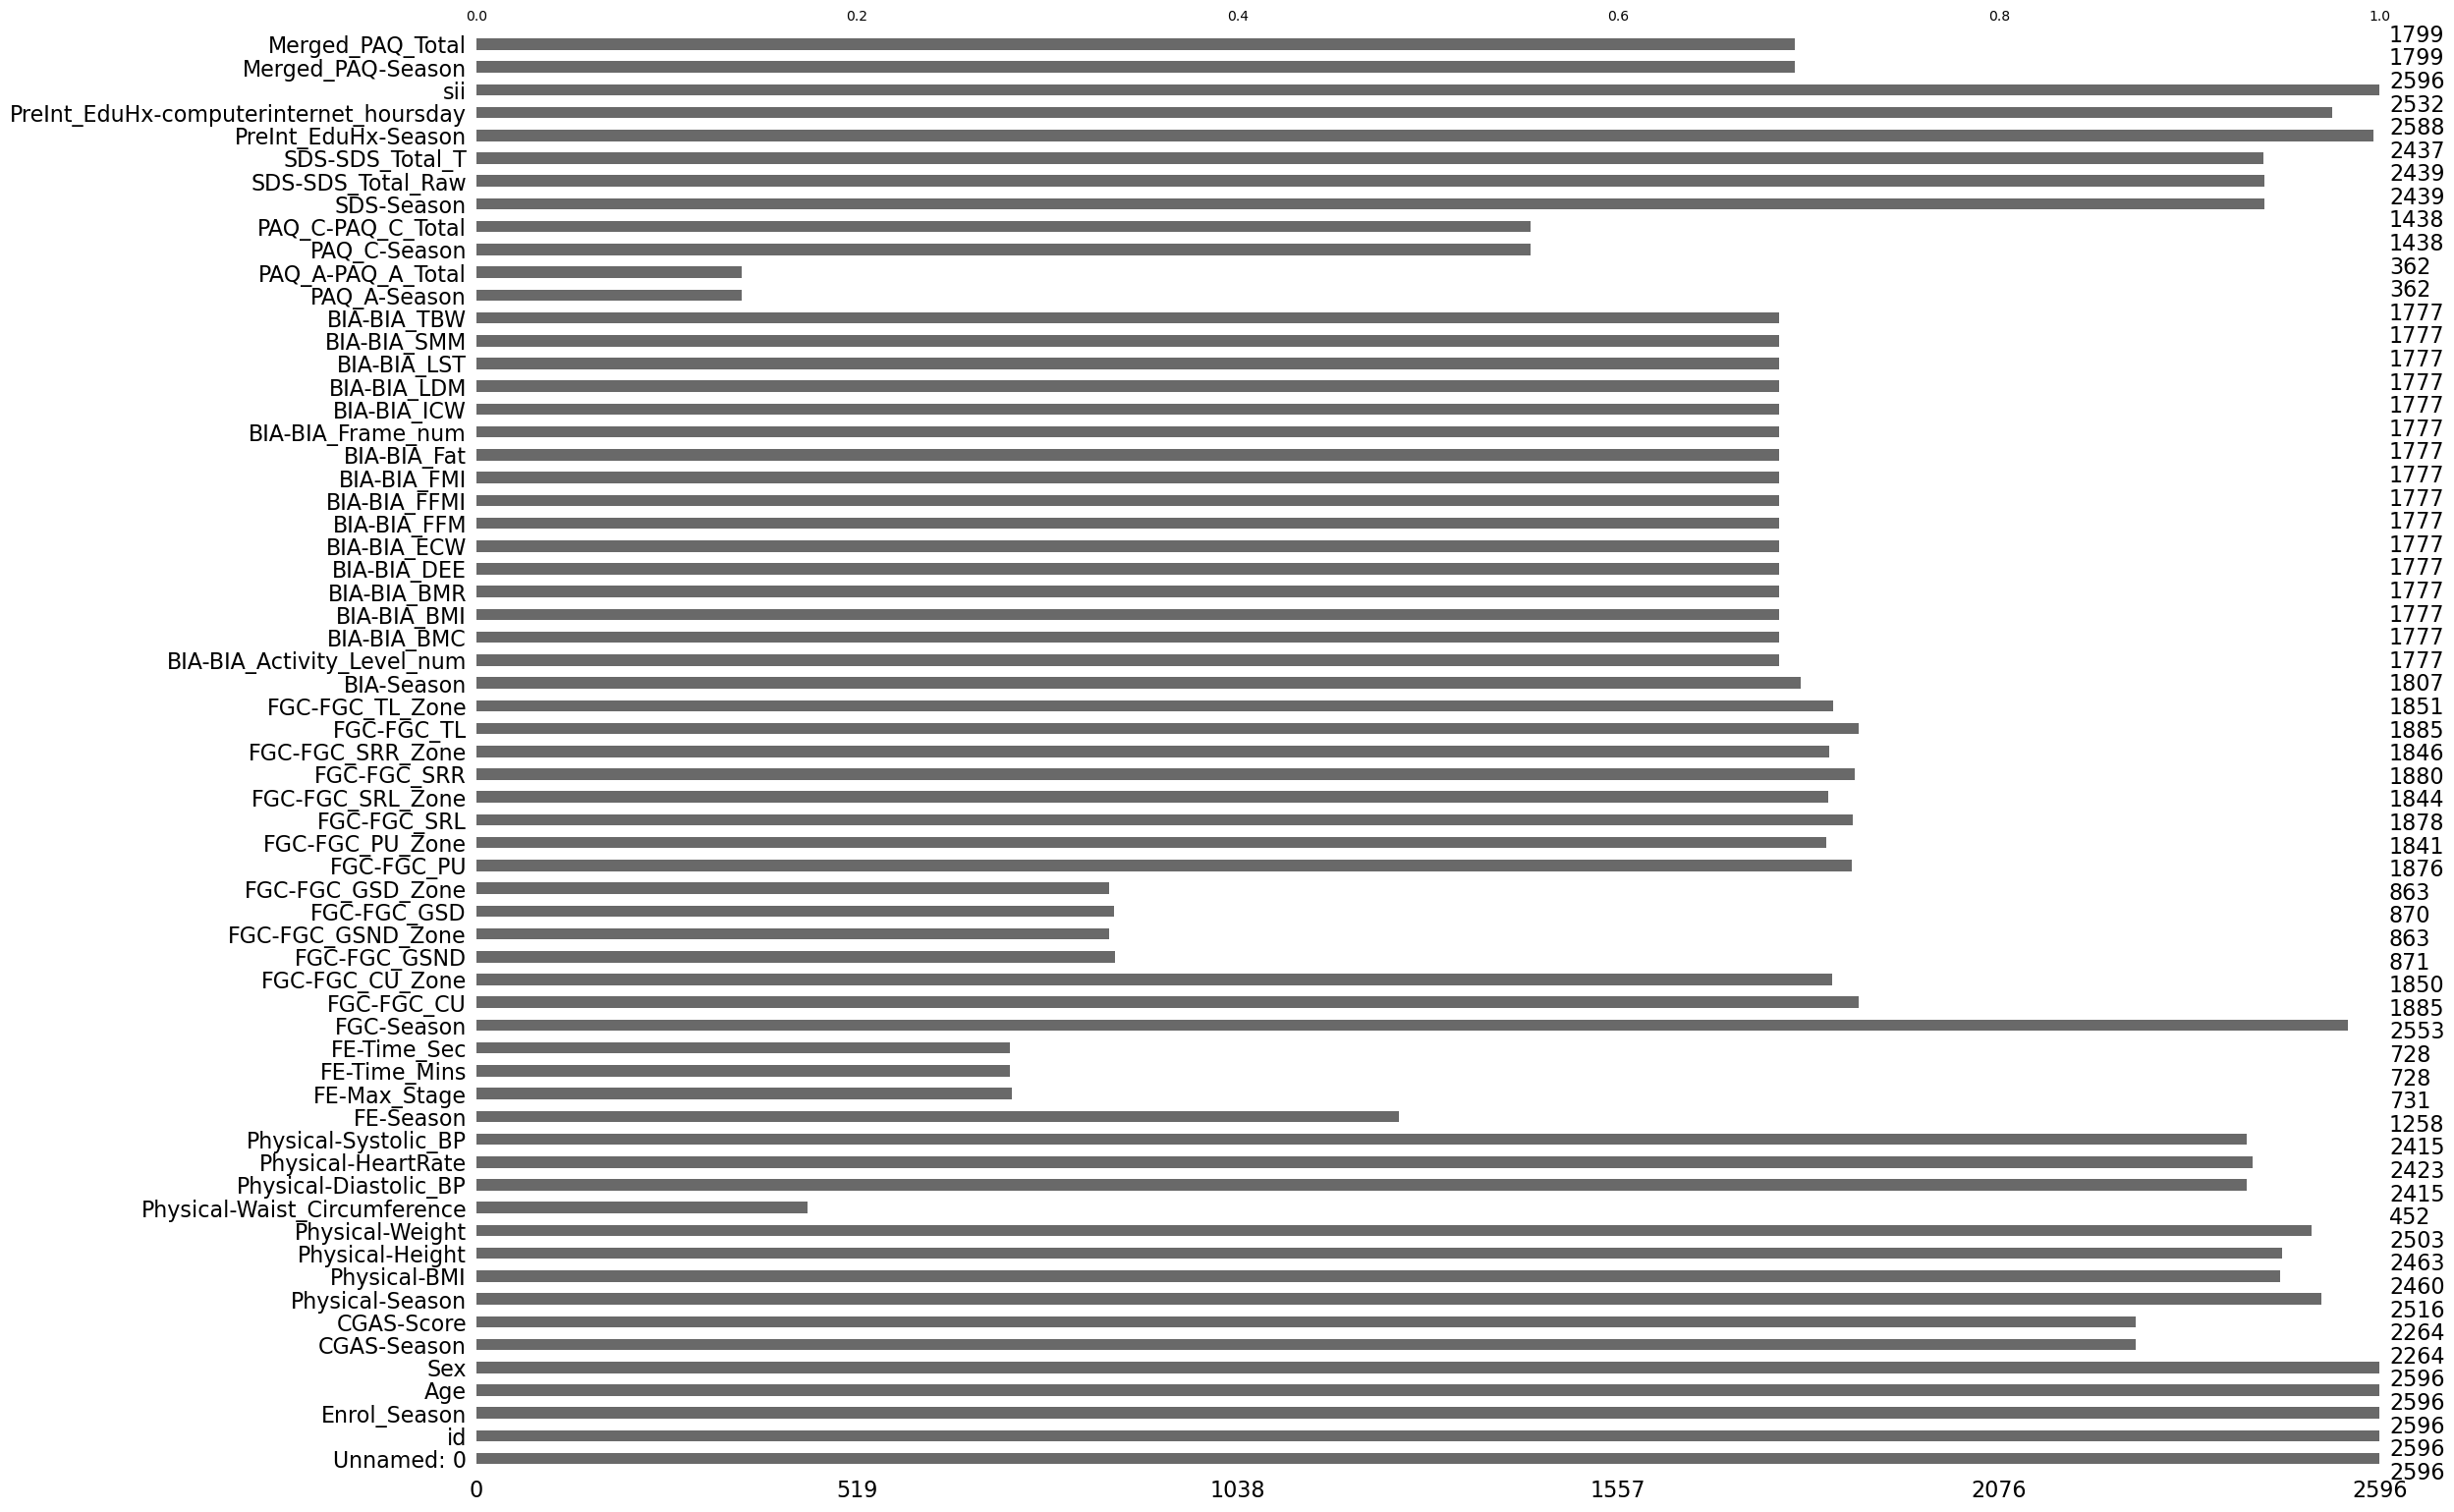

In [641]:
%matplotlib inline
msno.bar(df_hbn_sii)

In [642]:
df_hbn_sii_copy = df_hbn_sii.copy()

In [643]:
# drop columns with more than 40 percent NaN values: 

total_rows = df_hbn_sii.shape[0]

nan_percentage = df_hbn_sii.isnull().sum() / total_rows * 100

cols_to_drop = nan_percentage[nan_percentage > 40].index

print(cols_to_drop)

df_hbn_sii = df_hbn_sii.drop(columns=cols_to_drop, axis=1)

print(df_hbn_sii.info())


Index(['Physical-Waist_Circumference', 'FE-Season', 'FE-Max_Stage',
       'FE-Time_Mins', 'FE-Time_Sec', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone',
       'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total',
       'PAQ_C-Season', 'PAQ_C-PAQ_C_Total'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 2596 entries, 0 to 3958
Data columns (total 50 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              2596 non-null   int64  
 1   id                                      2596 non-null   object 
 2   Enrol_Season                            2596 non-null   object 
 3   Age                                     2596 non-null   int64  
 4   Sex                                     2596 non-null   int64  
 5   CGAS-Season                             2264 non-null   object 
 6   CGAS-Score                              2264 non-nul

In [644]:
# just start with some obvious features: 
df_hbn_sii.columns

Index(['Unnamed: 0', 'id', 'Enrol_Season', 'Age', 'Sex', 'CGAS-Season',
       'CGAS-Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height',
       'Physical-Weight', 'Physical-Diastolic_BP', 'Physical-HeartRate',
       'Physical-Systolic_BP', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone',
       'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC',
       'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW',
       'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat',
       'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-Season', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday', 'sii', 'Merged_PAQ-Season',
       'Merged_PAQ_Total'],
      dtype='object')

In [645]:
# just keep feature columns: 
# keep_columns = ['Age', 'Sex', 
#        'CGAS-Score', 'Physical-BMI', 'Physical-Height',
#        'Physical-Weight', 'Physical-Diastolic_BP', 'Physical-HeartRate',
#        'Physical-Systolic_BP',  'SDS-SDS_Total_Raw',
#        'SDS-SDS_Total_T', 
#        'PreInt_EduHx-computerinternet_hoursday', 'sii']


keep_columns = ['Age', 'Sex',
                'CGAS-Score', 'Physical-BMI',
                'Physical-Diastolic_BP', 'Physical-HeartRate','Physical-Systolic_BP',
                 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone',
       'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC',
       'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW',
       'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat',
       'Merged_PAQ_Total',
       'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW',
       'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday', 'sii',]

df_hbn_X = df_hbn_sii[keep_columns].copy()
print(df_hbn_X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2596 entries, 0 to 3958
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     2596 non-null   int64  
 1   Sex                                     2596 non-null   int64  
 2   CGAS-Score                              2264 non-null   float64
 3   Physical-BMI                            2460 non-null   float64
 4   Physical-Diastolic_BP                   2415 non-null   float64
 5   Physical-HeartRate                      2423 non-null   float64
 6   Physical-Systolic_BP                    2415 non-null   float64
 7   FGC-FGC_CU                              1885 non-null   float64
 8   FGC-FGC_CU_Zone                         1850 non-null   float64
 9   FGC-FGC_PU                              1876 non-null   float64
 10  FGC-FGC_PU_Zone                         1841 non-null   float64
 

In [646]:
# fill numerical columns with median, categorical columns with mode

# num_cols = df_hbn_X.select_dtypes(include=[np.number]).columns
# cat_cols = df_hbn_X.select_dtypes(exclude=[np.number]).columns

# for col in num_cols:
#     col_med = df_hbn_X[col].median()
#     df_hbn_X[col] = df_hbn_X[col].fillna(col_med)
# for col in cat_cols:
#     col_mode = df_hbn_X[col].mode()[0]
#     df_hbn_X[col] = df_hbn_X[col].fillna(col_mode)

# print(df_hbn_X.info())


In [647]:
# print(df_hbn_X.info())
# Create a KNN imputer instance
imputer = KNNImputer(n_neighbors=6)  # Adjust n_neighbors as needed

# Perform imputation
imputed_data = imputer.fit_transform(df_hbn_X)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=df_hbn_X.columns, index=df_hbn_X.index)

print(imputed_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2596 entries, 0 to 3958
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     2596 non-null   float64
 1   Sex                                     2596 non-null   float64
 2   CGAS-Score                              2596 non-null   float64
 3   Physical-BMI                            2596 non-null   float64
 4   Physical-Diastolic_BP                   2596 non-null   float64
 5   Physical-HeartRate                      2596 non-null   float64
 6   Physical-Systolic_BP                    2596 non-null   float64
 7   FGC-FGC_CU                              2596 non-null   float64
 8   FGC-FGC_CU_Zone                         2596 non-null   float64
 9   FGC-FGC_PU                              2596 non-null   float64
 10  FGC-FGC_PU_Zone                         2596 non-null   float64
 

In [648]:
df_hbn_X = imputed_df.copy()

In [649]:

# encode categorical variables


In [650]:
df_hbn_X_copy = df_hbn_X.copy()

توزیع کلاس‌ها

In [651]:
df_hbn_X_copy['sii'].describe()

count    2596.000000
mean        0.584746
std         0.772443
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: sii, dtype: float64

sii
0    1504
1     699
2     360
3      33
Name: count, dtype: int64


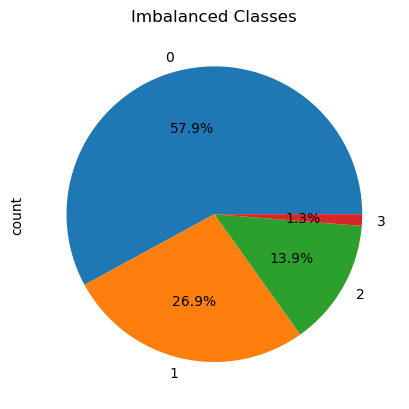

In [652]:
df_hbn_X_copy['sii'] = df_hbn_X_copy['sii'].astype('int64')
sii_counts = df_hbn_X_copy['sii'].value_counts()
print(sii_counts)
sii_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Imbalanced Classes')
plt.show()

In [653]:
# seperate target column
df_X = df_hbn_X.drop('sii', axis=1)
df_y = df_hbn_X['sii']

# test / train split

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, 
    test_size=0.15,   # 15% test
    random_state=42, # for reproducibility
    stratify=df_y       # keep target distribution consistent
)



In [654]:
# feature scaling


In [655]:
# model selection
# random forest with balanced class weights
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_clf = RandomForestClassifier(class_weight='balanced', 
                                n_estimators=100, 
                                random_state=42)
rf_clf.fit(X_train, y_train)  # not always mandatory to scale for tree-based methods

y_pred_rf = rf_clf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.5923076923076923
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.89      0.75       226
         1.0       0.37      0.22      0.27       105
         2.0       0.55      0.11      0.18        54
         3.0       0.00      0.00      0.00         5

    accuracy                           0.59       390
   macro avg       0.39      0.31      0.30       390
weighted avg       0.55      0.59      0.53       390



In [656]:
# SMOTE 

In [657]:
balanced_clf = BalancedRandomForestClassifier(
    sampling_strategy="all",
    replacement=True, 
    random_state=42,
    bootstrap=True,
    class_weight="balanced")
balanced_clf.fit(X_train, y_train)

y_pred_balanced = balanced_clf.predict(X_test)
print("Balanced Random Forest Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("Classification Report:\n", classification_report(y_test, y_pred_balanced))


Balanced Random Forest Accuracy: 0.4358974358974359
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.58      0.65       226
         1.0       0.25      0.22      0.23       105
         2.0       0.19      0.28      0.22        54
         3.0       0.04      0.40      0.08         5

    accuracy                           0.44       390
   macro avg       0.31      0.37      0.30       390
weighted avg       0.53      0.44      0.47       390



In [664]:

# Resampling using SMOTE for oversampling
over = SMOTE(sampling_strategy='auto', random_state=42)
under = RandomUnderSampler(sampling_strategy='auto', random_state=42)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_resampled, y_resampled = pipeline.fit_resample(df_X, df_y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42,
                                       class_weight='balanced')

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_smote = rf_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote))



Accuracy: 0.8446843853820598
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.78      0.77       301
         1.0       0.79      0.71      0.75       301
         2.0       0.83      0.89      0.86       301
         3.0       0.98      1.00      0.99       301

    accuracy                           0.84      1204
   macro avg       0.84      0.84      0.84      1204
weighted avg       0.84      0.84      0.84      1204

Confusion Matrix:
[[236  43  21   1]
 [ 54 213  32   2]
 [ 19  13 267   2]
 [  0   0   0 301]]


In [659]:
    

# hyperparameter tuning
# defaults
# without validation


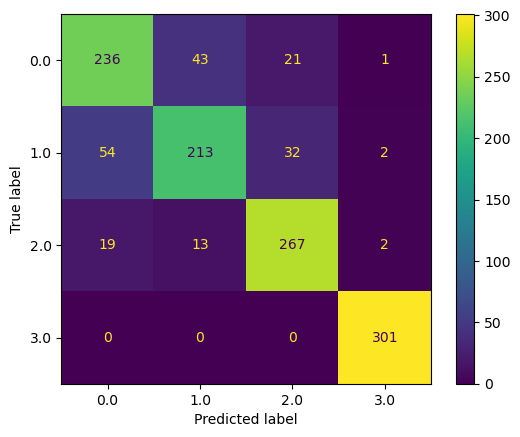

In [660]:
# model evaluation and error analysis
y_pred_best = y_pred_smote
best_model = rf_clf

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()


In [661]:
                                                                                

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.8330564784053156
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.78      0.75       301
         1.0       0.75      0.67      0.71       301
         2.0       0.87      0.88      0.87       301
         3.0       0.99      1.00      0.99       301

    accuracy                           0.83      1204
   macro avg       0.83      0.83      0.83      1204
weighted avg       0.83      0.83      0.83      1204



In [662]:



# without validation

# model deployment


